# Анализ комментариев на токсичность

Требуется инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучить модель классифицировать комментарии на позитивные и негативные. В распоряжении набор данных с разметкой о токсичности. правок.

Нужно построить модель со значением метрики качества *F1* не меньше 0.75. 

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

## Подготовка

Импортируем нужные нам библиотеки.

In [1]:
!pip install nltk
!pip install wordcloud

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer 
from lightgbm import LGBMRegressor
from tqdm.notebook import tqdm
from wordcloud import WordCloud
from sklearn.pipeline import Pipeline

In [3]:
nltk.download('stopwords') 
nltk.download('punkt') 
nltk.download('wordnet') 
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kalin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kalin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kalin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\kalin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\kalin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

Считаем данные из csv-файла в датафрейм и сохраним в переменную df.

In [4]:
df = pd.read_csv('toxic_comments.csv', index_col=0)

Выведим 10 строчек датафрейма

In [5]:
df.sample(10)

,text,toxic
121970,"""\n\nTo revert an article back to a prior vers...",0
34128,"Pók-spider, ember-man (both male and female).",0
132279,Id rather be a vandal than a snot nosed little...,1
42417,"""\n\n """"Pushing it"""" \n\nUnclear what you thin...",0
58841,"I also oppose deletion, and propose expansion,...",0
122969,"""\n\n MR X revert goon \n\nMr X prefers which ...",0
21891,"""\nYou're most welcome, of course. I actually ...",0
40160,it's common domain because the head of the Men...,0
16678,Image Tagging for Image:AlGoreHowardDean.jpg\n...,0
125926,"""\nWikipedia has plenty of built-in mechanisms...",0


Выведим основную информацию о датафрейме с помощью метода info().

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Выведим количество пропущенных значений в датафрейме.

In [7]:
df.isna().sum()

text     0
toxic    0
dtype: int64

Напишем функцию, которая убирает лишние символы и переводит текст в нижний регистр с помощью регулярного выражения

In [8]:
def clear_text(text):
    clear = re.sub(r'[^a-zA-Z ]', ' ', text.lower())
    clear = clear.split()
    return " ".join(clear)

In [9]:
df['lemm_text'] = df['text'].apply(clear_text)    

Лемматизируем текст 

In [10]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [11]:
def lemmatize(text):
    m = WordNetLemmatizer()
    word_list = nltk.word_tokenize(text)
    clear_text = ' '.join([m.lemmatize(w, get_wordnet_pos(w)) for w in word_list])
    return clear_text

In [12]:
tqdm.pandas()
df['lemm_text'] = df['lemm_text'].progress_apply(lemmatize)
df.tail(20)

  0%|          | 0/159292 [00:00<?, ?it/s]

,text,toxic,lemm_text
159431,While about half the references are from BYU-I...,0,while about half the reference be from byu i t...
159432,Prague Spring \n\nI think that Prague Spring d...,0,prague spring i think that prague spring deser...
159433,I see this as having been merged; undoing one ...,0,i see this a have be merge undo one side of a ...
159434,and i'm going to keep posting the stuff u dele...,1,and i m go to keep post the stuff u delete unt...
159435,"""\n\nHow come when you download that MP3 it's ...",0,how come when you download that mp it s title ...
159436,"I'll be on IRC, too, if you have a more specif...",0,i ll be on irc too if you have a more specific...
159437,It is my opinion that that happens to be off-t...,0,it be my opinion that that happens to be off t...
159438,Please stop removing content from Wikipedia; i...,0,please stop remove content from wikipedia it b...
159439,Image:Barack-obama-mother.jpg listed for delet...,0,image barack obama mother jpg list for deletio...
159440,"""Editing of article without Consensus & Remova...",0,edit of article without consensus removal of c...


Посмотрим на наиболее часто встречающиеся слова в комментариях

In [13]:
wordcloud_not_toxic = WordCloud().generate(' '.join(df[df.toxic == 0].lemm_text))
wordcloud_toxic = WordCloud().generate(' '.join(df[df.toxic == 1].lemm_text))

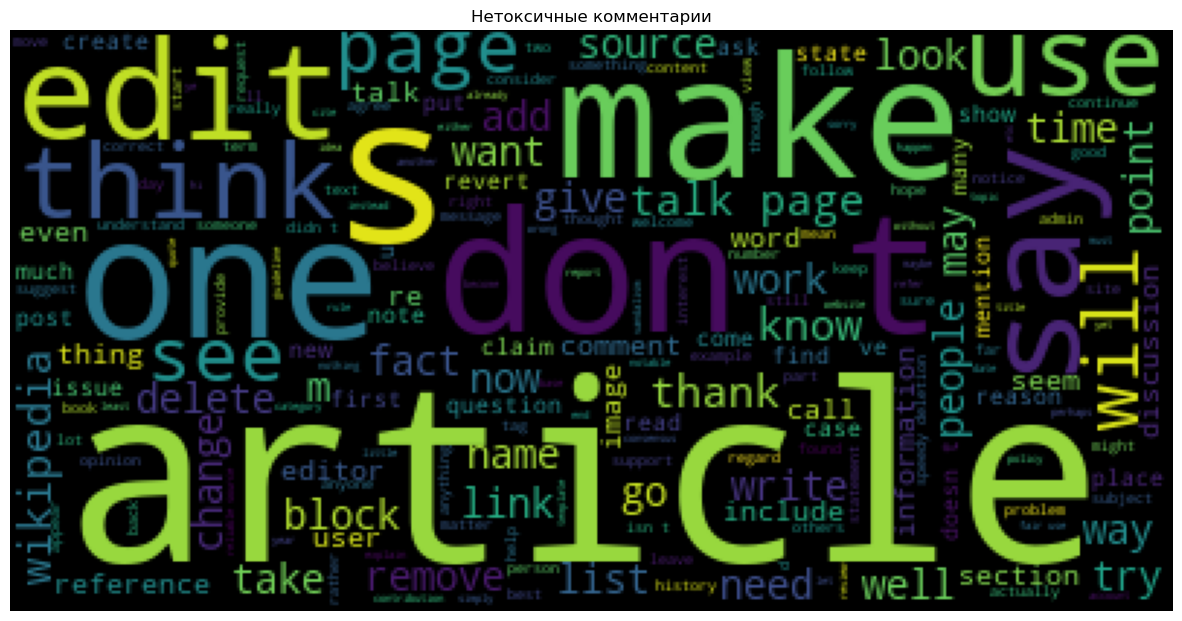

In [14]:
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud_not_toxic)
plt.axis("off")
plt.title('Нетоксичные комментарии')
plt.show()

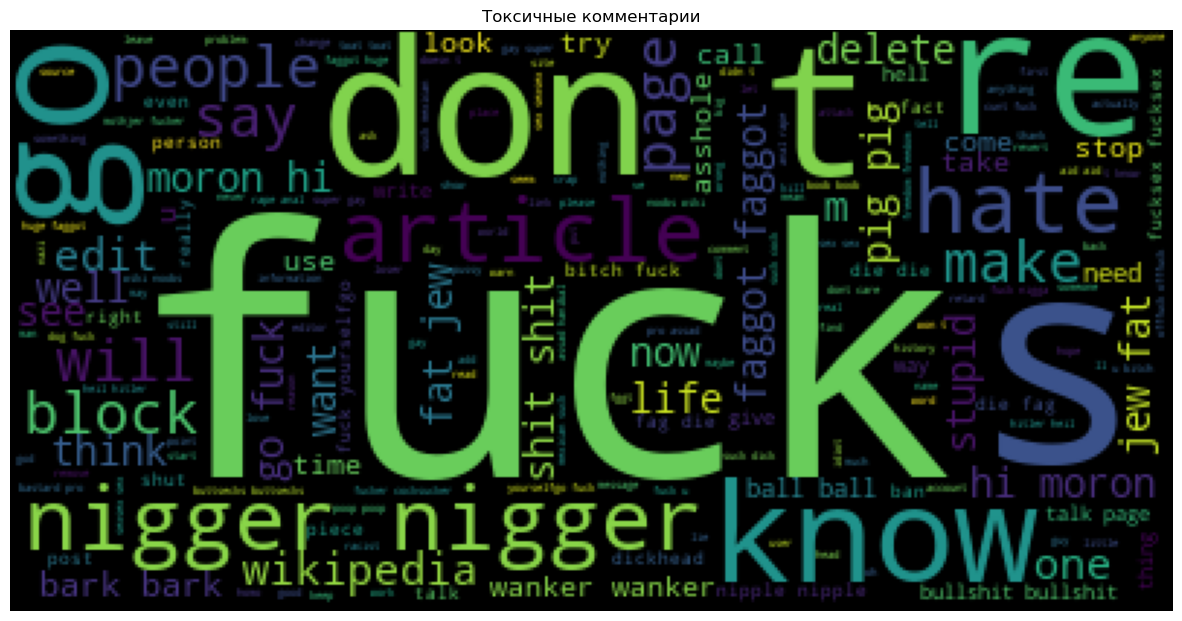

In [15]:
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud_toxic)
plt.axis("off")
plt.title('Токсичные комментарии')
plt.show()

## Обучение

Подготовим выборки для обучения моделей.

In [16]:
features = df['lemm_text']
target = df['toxic']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=12345, stratify=target)

Создадим корпуса для обучающей и тестовой выборки 

In [17]:
corpus_train = features_train.values
corpus_test = features_test.values

Вычислим TF-IDF для корпусов 

In [18]:
count_tf_idf = TfidfVectorizer(stop_words=set(stopwords.words('english'))) 
tf_idf_train = count_tf_idf.fit_transform(corpus_train) 
tf_idf_test = count_tf_idf.transform(corpus_test)

Обучим модель LightGBM, найдём лучшие параметры с помощью `GridSearchCV`

In [20]:
from lightgbm import LGBMClassifier
parametrs = { 
              'model__learning_rate': [0.1, 0.2, 0.3] ,
             }

pipeline = Pipeline([
    ('vect', TfidfVectorizer(stop_words=set(stopwords.words('english')))),
    ('model', LGBMClassifier(random_state=12345))])

grid_LGBM = GridSearchCV(pipeline, parametrs, cv=5, scoring="f1", verbose=10)
grid_LGBM.fit(features_train, target_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5; 1/3] START model__learning_rate=0.1....................................
[CV 1/5; 1/3] END .....model__learning_rate=0.1;, score=0.750 total time=  17.9s
[CV 2/5; 1/3] START model__learning_rate=0.1....................................
[CV 2/5; 1/3] END .....model__learning_rate=0.1;, score=0.745 total time=  17.9s
[CV 3/5; 1/3] START model__learning_rate=0.1....................................
[CV 3/5; 1/3] END .....model__learning_rate=0.1;, score=0.755 total time=  17.8s
[CV 4/5; 1/3] START model__learning_rate=0.1....................................
[CV 4/5; 1/3] END .....model__learning_rate=0.1;, score=0.738 total time=  18.0s
[CV 5/5; 1/3] START model__learning_rate=0.1....................................
[CV 5/5; 1/3] END .....model__learning_rate=0.1;, score=0.747 total time=  19.0s
[CV 1/5; 2/3] START model__learning_rate=0.2....................................
[CV 1/5; 2/3] END .....model__learning_rate=0.2;,

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(stop_words={'a',
                                                                    'about',
                                                                    'above',
                                                                    'after',
                                                                    'again',
                                                                    'against',
                                                                    'ain',
                                                                    'all', 'am',
                                                                    'an', 'and',
                                                                    'any',
                                                                    'are',
                                                                    'aren',
          

Обучим модель логистической регрессии, найдём лучшие параметры с помощью `GridSearchCV`

In [21]:
%%time
parametrs = { 
              'model__max_iter': [300],   
              'model__class_weight': ['balanced'],
              'model__C': [3, 4, 5]
             }

pipeline = Pipeline([
    ('vect', TfidfVectorizer(stop_words=set(stopwords.words('english')))),
    ('model', LogisticRegression(random_state=12345))])

grid_LR = GridSearchCV(pipeline, parametrs, scoring="f1", verbose=10)
grid_LR.fit(features_train, target_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5; 1/3] START model__C=3, model__class_weight=balanced, model__max_iter=300
[CV 1/5; 1/3] END model__C=3, model__class_weight=balanced, model__max_iter=300;, score=0.753 total time=   7.0s
[CV 2/5; 1/3] START model__C=3, model__class_weight=balanced, model__max_iter=300
[CV 2/5; 1/3] END model__C=3, model__class_weight=balanced, model__max_iter=300;, score=0.751 total time=   8.5s
[CV 3/5; 1/3] START model__C=3, model__class_weight=balanced, model__max_iter=300
[CV 3/5; 1/3] END model__C=3, model__class_weight=balanced, model__max_iter=300;, score=0.754 total time=   6.8s
[CV 4/5; 1/3] START model__C=3, model__class_weight=balanced, model__max_iter=300
[CV 4/5; 1/3] END model__C=3, model__class_weight=balanced, model__max_iter=300;, score=0.754 total time=   7.8s
[CV 5/5; 1/3] START model__C=3, model__class_weight=balanced, model__max_iter=300
[CV 5/5; 1/3] END model__C=3, model__class_weight=balanced, model__max_iter=30

GridSearchCV(estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(stop_words={'a',
                                                                    'about',
                                                                    'above',
                                                                    'after',
                                                                    'again',
                                                                    'against',
                                                                    'ain',
                                                                    'all', 'am',
                                                                    'an', 'and',
                                                                    'any',
                                                                    'are',
                                                                    'aren',
                             

Сравним качество моделей метрикой F1

In [22]:
print(f'Качество LightGBM F1:', grid_LGBM.best_score_)
print(f'Качество модели логистической регрессии F1:', grid_LR.best_score_)

Качество LightGBM F1: 0.7673850870485489
Качество модели логистической регрессии F1: 0.7555078548577219


**Вывод:** Лучшая модель - LightGBM. Проверим её качество на тестовой выборке.

In [23]:
predict = grid_LGBM.predict(features_test)
f1_score(target_test, predict)

0.7800929912174962

## Выводы

1. Загрузили данные
2. Подготовили данные для обучения. Очистили текст от лишних символов, провели лемматизацию 
3. Обучили две модели: логистическую регрессию и модель дерева решений, подобрали лучшие параметры
4. Показатель F1 лучше у модели логистической регрессии на кросс-валидации, и он больше 0.75
5. На тестовой выборке у логистической регрессии показатель F1 - 0.7615230460921845